# Generation of datasets to train the berry detection and segmentation models

In [2]:
import cv2
import json
import numpy as np
import matplotlib.pyplot as plt

from openalea.deepberry.training.training_dataset import labelme_json_postprocessing, generate_detection_instance, generate_segmentation_instance
from openalea.deepberry.utils import ellipse_interpolation

from datadir import datadir

# 1. Loading of annotated data

## Loads an image an its corresponding labels Each label is a polygon. Only berries with >50% contours visible were annotated. Polygon points must only be placed were these contours are visible.

In [3]:
image = cv2.cvtColor(cv2.imread(datadir + '/training/image.png'), cv2.COLOR_BGR2RGB)

labels_path = datadir + '/training/labels.json'
with open(labels_path) as f:
    raw_labels = json.load(f)

## Displays it

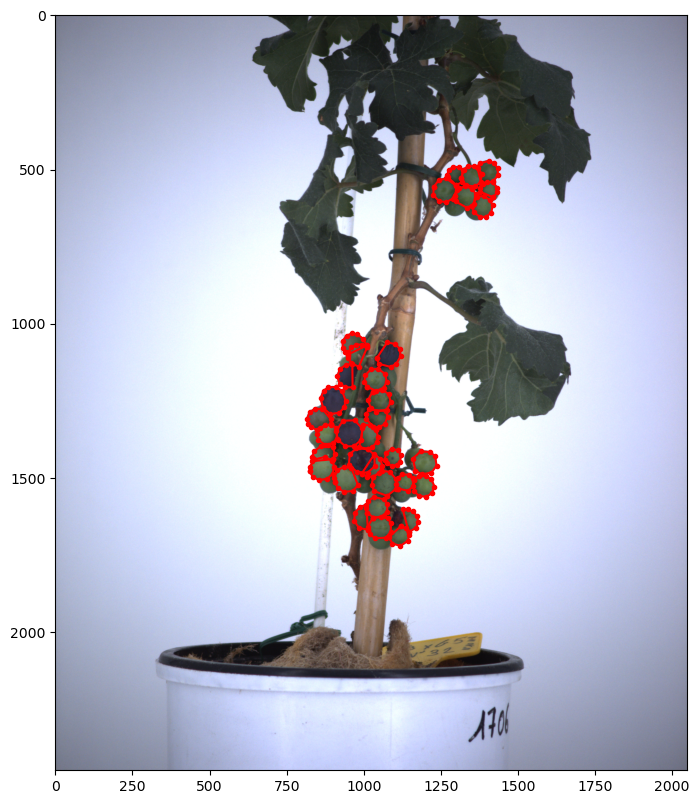

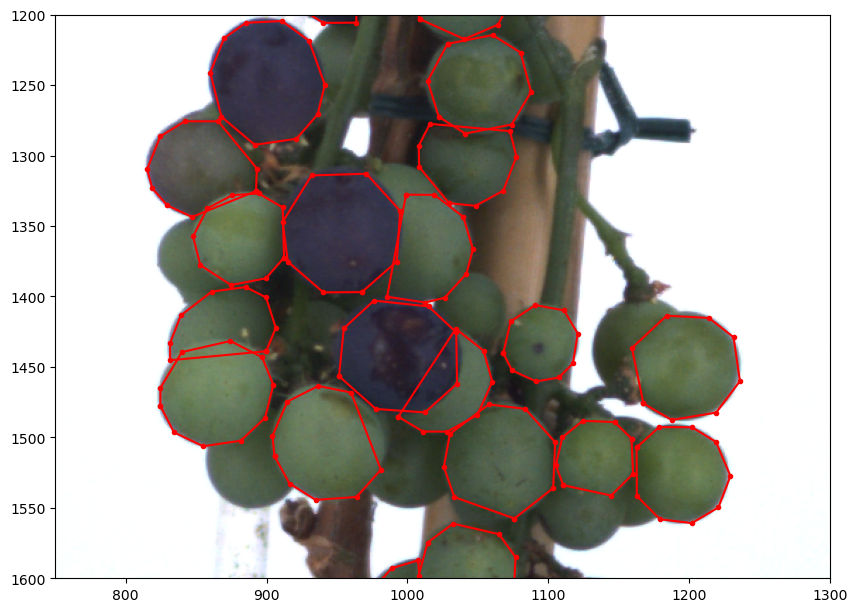

In [4]:
for zoom in [False, True]:
    _ = plt.subplots(figsize=(10, 10), dpi=100)
    plt.imshow(image)
    for shape in raw_labels['shapes']:
        points = np.array(shape['points'])
        points = np.concatenate((points, [points[0]]))
        plt.plot(points[:, 0], points[:, 1], 'r.-')
        if zoom: 
            plt.xlim((750, 1300))
            plt.ylim((1600, 1200))

# 2. Conversion of the labels to box & ellipse parameters

## Converts polygon labels from the .json Labelme format to ellipse and box parameters, using ellipse fitting

In [5]:
labels = labelme_json_postprocessing(labels_path)

## Displays a few rows from the reformatted labels

In [6]:
print(labels.iloc[:5])

         ell_x       ell_y      ell_w      ell_h       ell_a        box_x  \
0  1298.132202  518.919495  54.202049  59.932858  167.553940  1298.132202   
1  1348.776367  521.626099  68.387878  69.524399  175.206879  1348.776367   
2  1329.076172  588.526428  69.298958  70.581642   12.114693  1329.076172   
3  1262.060547  566.753113  75.269562  79.666199   45.031830  1262.060547   
4  1383.757935  619.144653  65.862106  71.608299  146.561005  1383.757935   

        box_y      box_w      box_h  
0  518.919495  54.474683  59.670038  
1  521.626099  68.386157  69.501990  
2  588.526428  69.344433  70.509425  
3  566.753113  77.490734  77.486244  
4  619.144653  67.649554  69.903179  


## Displays the resulting boxes (blue) and ellipses (orange) on the image

(1736.965087890625, 458.7367248535156)

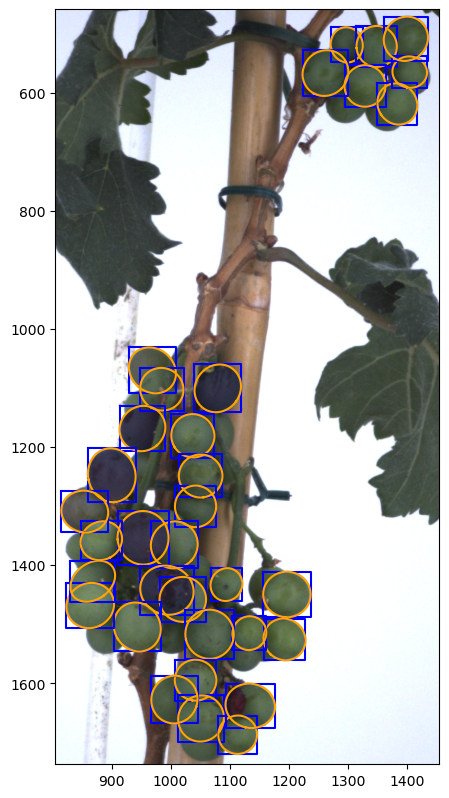

In [7]:
_ = plt.subplots(figsize=(10, 10), dpi=100)
plt.imshow(image)
for _, (xe, ye, we, he, ae, xb, yb, wb, hb) in labels.iterrows():
    # box
    plt.plot([xb - wb/2, xb - wb/2, xb + wb/2, xb + wb/2, xb - wb/2], 
             [yb - hb/2, yb + hb/2, yb + hb/2, yb - hb/2, yb - hb/2], 'b-')
    # ellipse
    lsp_x, lsp_y = ellipse_interpolation(x=xe, y=ye, w=we, h=he, a=ae, n_points=50)
    plt.plot(lsp_x, lsp_y, '-', color='orange')
# zoom
plt.xlim((min(labels['box_x']) - 50, max(labels['box_x']) + 50))
plt.ylim((max(labels['box_y']) + 50, min(labels['box_y']) - 50))

# 3. Generates an instance to train the Yolov4 detection model

## Crops and saves a 416x416 vignette (.png) from the original image, and its corresponding labels (.txt), with data augmentation.

In [10]:
output_path = datadir + '/det_instance1'
_ = generate_detection_instance(image=image, labels=labels, dirsave=output_path, 
                                target_center=None)

## Loads and displays it

label file in the yolov4 format : 

0 0.44963425856370187 0.5742680476262019 0.18691476265022927 0.19156253912380697

0 0.5264349717360276 0.5360560783973107 0.17375701037274693 0.1767398901219284

0 0.6863878690279447 0.6147820399357722 0.18463353298049376 0.18624643415576997

0 0.8763941251314603 0.7395980541522686 0.21965456841234826 0.19428567095964247

0 0.5228758591871995 0.30840301513671875 0.19464125607405144 0.18931911371486565

0 0.7159282977764423 0.4097240154559796 0.17678962617193314 0.17554965721630383

0 0.8795582697941706 0.3780799278846154 0.17502044880431755 0.17748292945093033



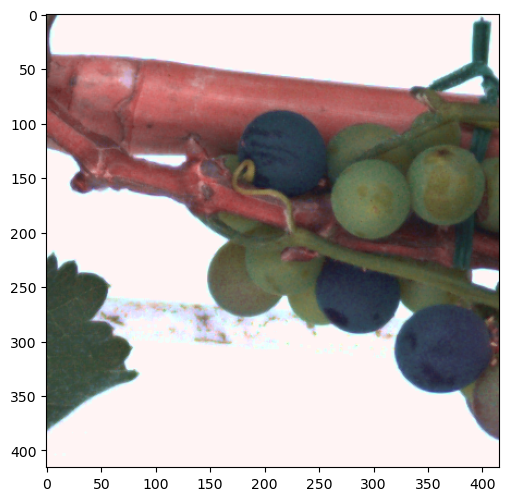

In [11]:
vignette = cv2.cvtColor(cv2.imread(f'{output_path}.png'), cv2.COLOR_BGR2RGB)
with open(f'{output_path}.txt') as f:
    label = f.readlines()
    
print('label file in the yolov4 format : \n')
for line in label:
    print(line)
    
fig, ax = plt.subplots(figsize=(6, 6), dpi=100)
plt.imshow(vignette)

## In the previous code section, the center position used to crop the vignette was chosen randomly: it may often result in a vignette with no berries. Instead, the center of a berry can be used as a rough target position for the cropping.

In [13]:
output_path2 = datadir + '/det_instance2'
_ = generate_detection_instance(image=image, labels=labels, dirsave=output_path2, 
                                target_center=tuple(labels.iloc[0][['ell_x', 'ell_y']]), 
                                random_center_proba=0)

## Loads and displays the new instance

label file in the yolov4 format : 

0 0.47564374483548677 0.47134736868051386 0.13094875664741706 0.14343759168697218

0 0.35390296349158656 0.46484110905573917 0.16438979933026915 0.16707209074850043

0 0.4012592022235577 0.30402300908015323 0.16669334942918057 0.16949381034142272

0 0.5623544546274039 0.35636270963228667 0.18627580237030428 0.18626501017578925

0 0.2698126572829026 0.23042150644155646 0.16261911918382965 0.16803648825343048

0 0.2194281357985276 0.36035743126502406 0.1408199113596911 0.12813648848330098

0 0.2350457998422476 0.49582518064058745 0.17993268525264156 0.18036859696011612



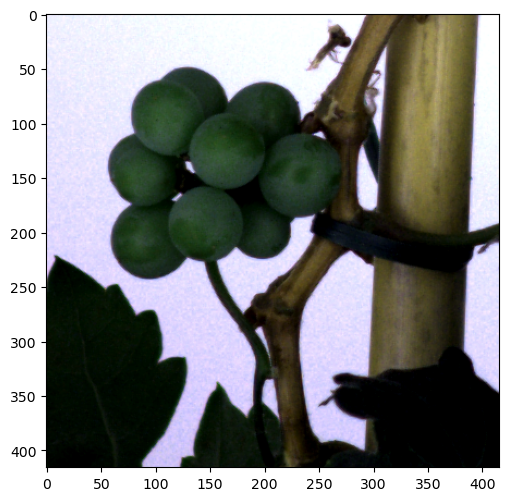

In [14]:
vignette = cv2.cvtColor(cv2.imread(f'{output_path2}.png'), cv2.COLOR_BGR2RGB)
with open(f'{output_path2}.txt') as f:
    label = f.readlines()
    
print('label file in the yolov4 format : \n')
for line in label:
    print(line)
    
fig, ax = plt.subplots(figsize=(6, 6), dpi=100)
plt.imshow(vignette)

# 4. Generates an instance to train the U-Net segmentation model

## Crops and saves a 128x128 vignette (.png) from the original image, and its corresponding 128x128 vignette label (.png)

In [17]:
_ = generate_segmentation_instance(image=image, label=labels.iloc[0], dirsave=datadir + '/seg_instance')

## Displays it

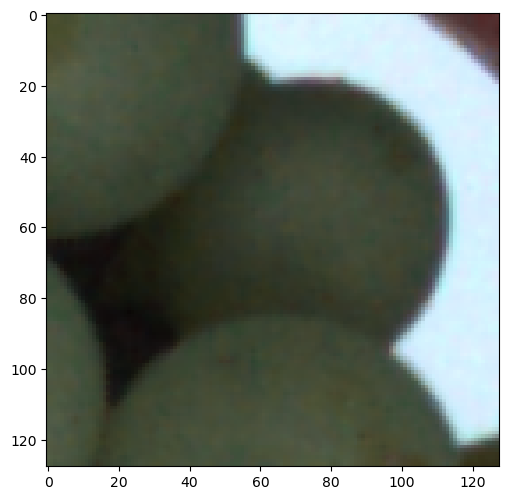

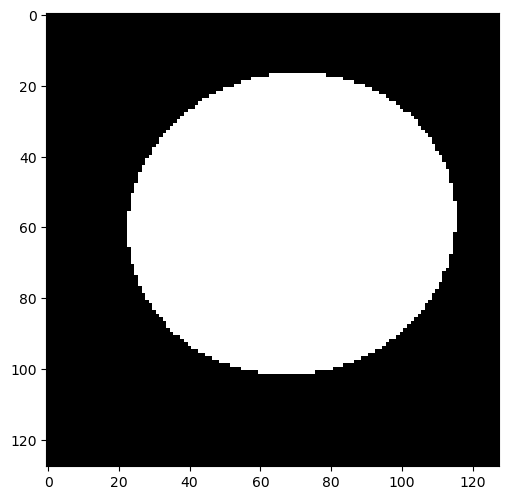

In [18]:
x = cv2.cvtColor(cv2.imread(datadir + '/seg_instancex.png'), cv2.COLOR_BGR2RGB)
y = cv2.cvtColor(cv2.imread(datadir + '/seg_instancey.png'), cv2.COLOR_BGR2RGB)
fig, ax = plt.subplots(figsize=(6, 6), dpi=100)
plt.imshow(x)
fig, ax = plt.subplots(figsize=(6, 6), dpi=100)
plt.imshow(y)